In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from IPython.display import display

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [2]:
train_df = pd.read_csv("data/train.csv")

In [3]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
idsUnique = len(set(train_df.Id))
idsTotal = train_df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1460 total entries


In [5]:
train_df.drop("Id", axis=1, inplace=True)

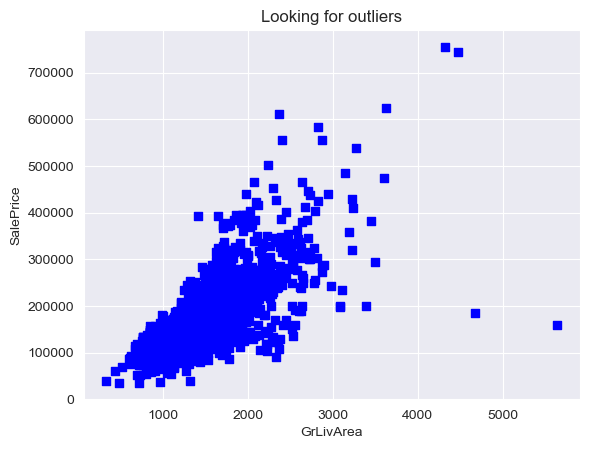

In [7]:
plt.scatter(x=train_df.GrLivArea, y=train_df.SalePrice, c='blue', marker='s')
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [8]:
train_df = train_df[train_df.GrLivArea < 4000]

In [10]:
train_df.SalePrice = np.log1p(train_df.SalePrice)
y = train_df.SalePrice

In [12]:
# Alley : data description says NA means "no alley access"
train_df.loc[:, "Alley"] = train_df.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train_df.loc[:, "BedroomAbvGr"] = train_df.loc[:, "BedroomAbvGr"].fillna(0)

In [13]:
train_df.loc[:, "BsmtQual"] = train_df.loc[:, "BsmtQual"].fillna("No")
train_df.loc[:, "BsmtCond"] = train_df.loc[:, "BsmtCond"].fillna("No")
train_df.loc[:, "BsmtExposure"] = train_df.loc[:, "BsmtExposure"].fillna("No")
train_df.loc[:, "BsmtFinType1"] = train_df.loc[:, "BsmtFinType1"].fillna("No")
train_df.loc[:, "BsmtFinType2"] = train_df.loc[:, "BsmtFinType2"].fillna("No")
train_df.loc[:, "BsmtFullBath"] = train_df.loc[:, "BsmtFullBath"].fillna(0)
train_df.loc[:, "BsmtHalfBath"] = train_df.loc[:, "BsmtHalfBath"].fillna(0)
train_df.loc[:, "BsmtUnfSF"] = train_df.loc[:, "BsmtUnfSF"].fillna(0)

In [14]:
# CentralAir : NA most likely means No
train_df.loc[:, "CentralAir"] = train_df.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train_df.loc[:, "Condition1"] = train_df.loc[:, "Condition1"].fillna("Norm")
train_df.loc[:, "Condition2"] = train_df.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train_df.loc[:, "EnclosedPorch"] = train_df.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train_df.loc[:, "ExterCond"] = train_df.loc[:, "ExterCond"].fillna("TA")
train_df.loc[:, "ExterQual"] = train_df.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train_df.loc[:, "Fence"] = train_df.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train_df.loc[:, "FireplaceQu"] = train_df.loc[:, "FireplaceQu"].fillna("No")
train_df.loc[:, "Fireplaces"] = train_df.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train_df.loc[:, "Functional"] = train_df.loc[:, "Functional"].fillna("Typ")

In [15]:
# GarageType etc : data description says NA for garage features is "no garage"
train_df.loc[:, "GarageType"] = train_df.loc[:, "GarageType"].fillna("No")
train_df.loc[:, "GarageFinish"] = train_df.loc[:, "GarageFinish"].fillna("No")
train_df.loc[:, "GarageQual"] = train_df.loc[:, "GarageQual"].fillna("No")
train_df.loc[:, "GarageCond"] = train_df.loc[:, "GarageCond"].fillna("No")
train_df.loc[:, "GarageArea"] = train_df.loc[:, "GarageArea"].fillna(0)
train_df.loc[:, "GarageCars"] = train_df.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train_df.loc[:, "HalfBath"] = train_df.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train_df.loc[:, "HeatingQC"] = train_df.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train_df.loc[:, "KitchenAbvGr"] = train_df.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train_df.loc[:, "KitchenQual"] = train_df.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train_df.loc[:, "LotFrontage"] = train_df.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train_df.loc[:, "LotShape"] = train_df.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train_df.loc[:, "MasVnrType"] = train_df.loc[:, "MasVnrType"].fillna("None")
train_df.loc[:, "MasVnrArea"] = train_df.loc[:, "MasVnrArea"].fillna(0)

In [17]:
# MiscFeature : data description says NA means "no misc feature"
train_df.loc[:, "MiscFeature"] = train_df.loc[:, "MiscFeature"].fillna("No")
train_df.loc[:, "MiscVal"] = train_df.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train_df.loc[:, "OpenPorchSF"] = train_df.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train_df.loc[:, "PavedDrive"] = train_df.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train_df.loc[:, "PoolQC"] = train_df.loc[:, "PoolQC"].fillna("No")
train_df.loc[:, "PoolArea"] = train_df.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train_df.loc[:, "SaleCondition"] = train_df.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train_df.loc[:, "ScreenPorch"] = train_df.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train_df.loc[:, "TotRmsAbvGrd"] = train_df.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train_df.loc[:, "Utilities"] = train_df.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train_df.loc[:, "WoodDeckSF"] = train_df.loc[:, "WoodDeckSF"].fillna(0)